# Decision Tree
Admission to masters’ degree programs (likely or unlikely?)



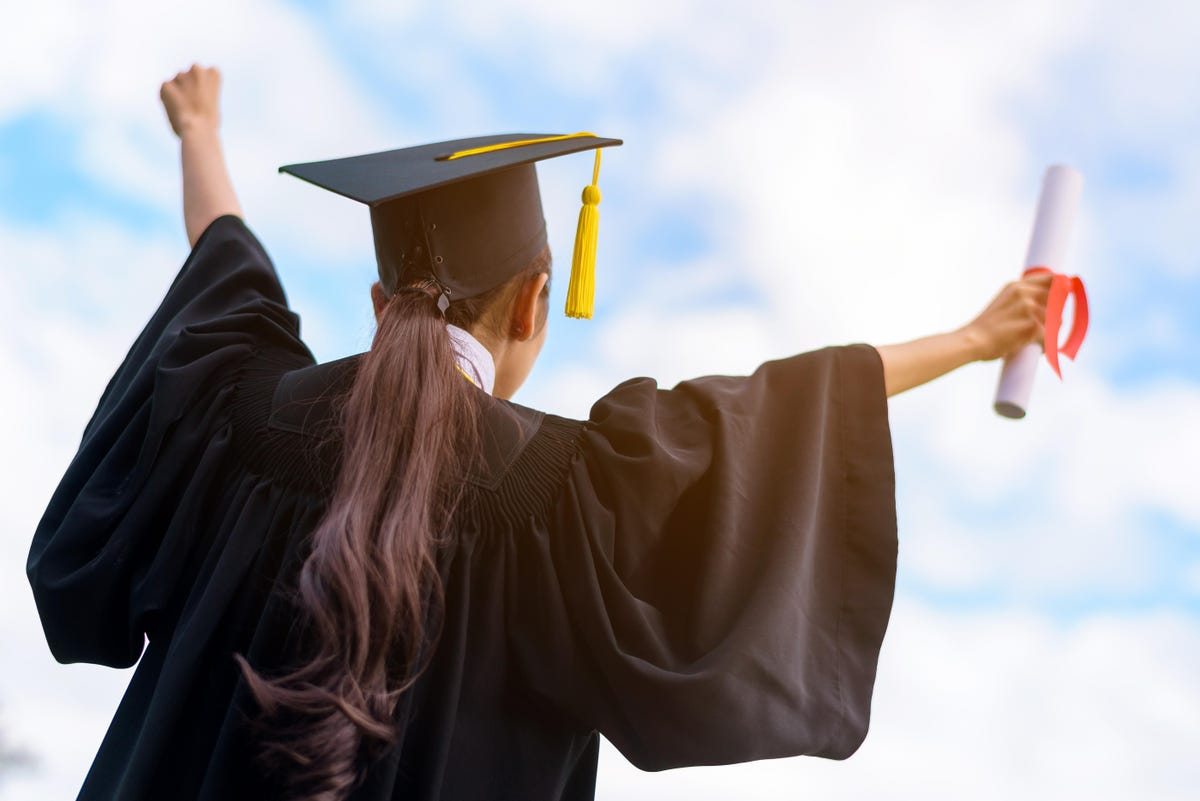

Data Source: [Admission to Master's Degree](https://www.kaggle.com/datasets/mohansacharya/graduate-admissions?select=Admission_Predict_Ver1.1.csv)

`About the Project:`

A classification prediction model(Desicion Tree) that will help students in shortlisting universities with their profiles. The predicted output gives them a fair idea about their chances for likelyhood of being admit or not.

`About the Dataset:`

The data contains features commonly used in determining admission to masters’ degree programs, such as GRE, GPA, and letters of recommendation. The complete list of features is summarized below:

- GRE Scores ( out of 340 )
- TOEFL Scores ( out of 120 )
- University Rating ( out of 5 )
- SOP/Statement of Purpose ( out of 5 )
- LOR/Letter of Recommendation ( out of 5 )
- Undergraduate GPA ( out of 10 )
- Research Experience ( either 0 or 1 )
- Chance of Admit ( ranging from 0 to 1 )

`Content:`
1. Import Libraries and Load Dataset
2. Preliminary Decision Tree
3. Evaluation
4. Decision Tree Pruning
5. Pruned Decission Tree
6. Random Forest Implementation
7. Conclusion

***

# 1. Import Libraries and Load Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score,confusion_matrix, plot_confusion_matrix
from sklearn import tree
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Admission_Predict.csv")
print(df.shape)
df.head(2)

(400, 9)


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76


In [3]:
# Cleaning columns names
df.columns = df.columns.str.strip().str.replace(' ','_').str.lower()
df.head(1)

,serial_no.,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92


# 2. Preliminary Decision Tree
NOTE: The decision tree does not support categorical data as features.

As a first step, we will create a binary class (1=admission likely , 0=admission unlikely) from the chance of admit – greater than 79% we will consider as likely. The remaining data columns will be used as predictors.

In [4]:
# Define X and y
X = df.loc[:,'gre_score':'research']
y = df['chance_of_admit']>=.79

In [5]:
# Data split
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.3)

`Note:`

In most decision tree, we are just comparing stuff and branching down the tree, so normalization would not help here.

### Decision Tree Classifier Object 

In [6]:
# parameters are all on default 
dt = DecisionTreeClassifier(random_state=0)

In [7]:
# Fit training data
dt.fit(x_train, y_train)

DecisionTreeClassifier(random_state=0)

### Visualization

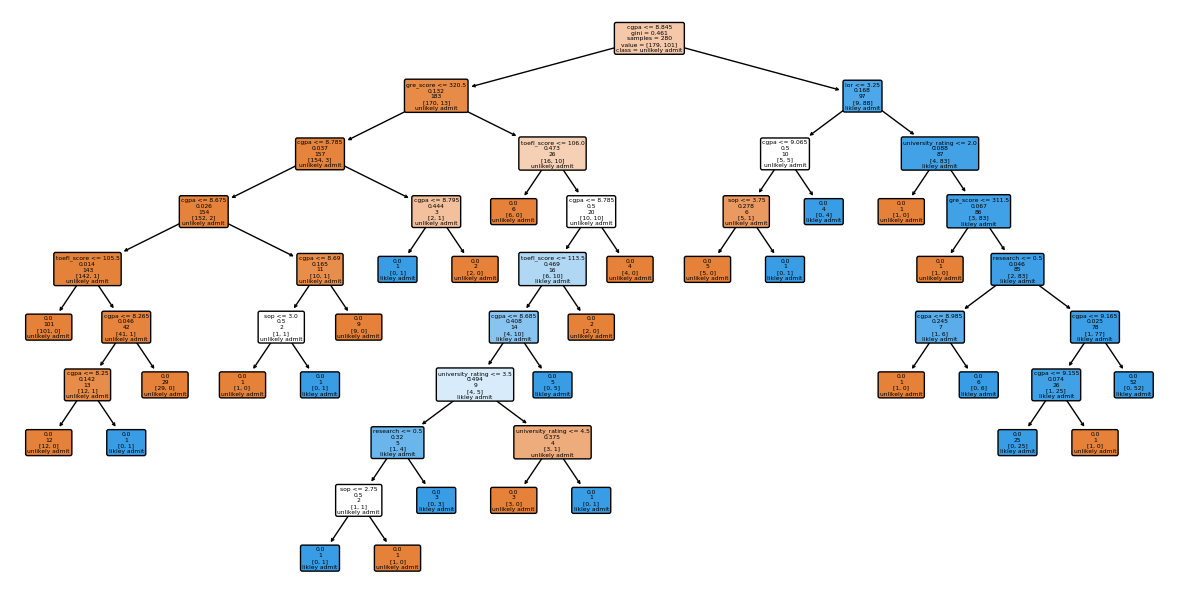

In [8]:
plt.figure(figsize=(15, 7.5))

tree.plot_tree(dt, 
               feature_names = x_train.columns,
               max_depth=None,
               class_names = ['unlikely admit', 'likley admit'],
               label='root',
               filled=True,
               rounded = True)
plt.show()

Desicion tree's are prone to overfit which make the trainning dataset score consistently high and a low score in testing dataset. 

`Questions` 

1. How does decision tree chooses it's root node?
 - Decision tree iterate through each features and compare for it's GINI Impurity. The lowest GINI impurity will be the root node. It can continue branching until it reach it's purest leave node.
2. How was the split cgpa <= 8.845 determined?
 - Cgpa is a continuous variable, which adds an extra complication, as the split can occur for ANY value of cgpa. We can also do a Feature Engineering like encoding this cgpa to a 'pass' or 'fail' which will make it easier.  


To verify, we will use the defined functions `gini` and `info_gain`. By running gini(y_train), we get the same Gini impurity value as printed in the tree at the root node which is 0.461.
 

In [9]:
# Gini function
def gini(data):
    """Calculate the Gini Impurity Score
    """
    data = pd.Series(data)
    return 1 - sum(data.value_counts(normalize=True)**2)

In [10]:
gi = gini(y_train)
# gini impurity at root node
gi

0.46119897959183676

Next, we are going to verify how the split on cgpa was determined, i.e. where did the 8.845 value come from. We will use 'info_gain function' to all the values of cgpa to determine the information gain when split on each value. 

The result will be stored in a table in sorted order

In [11]:
# Info_gain function
def info_gain(left, right, current_impurity):
    """Information Gain associated with creating a node/split data.
    Input: left, right are data in left branch, right banch, respectively
    current_impurity is the data impurity before splitting into left, right branches
    """
    # weight for gini score of the left branch
    w = float(len(left)) / (len(left) + len(right))
    return current_impurity - w * gini(left) - (1 - w) * gini(right)

In [12]:
# Inforamation gain list for cgpa
info_gain_list = []

# we just need pass the cgpa here (x_train.cgpa)
for i in x_train.cgpa.unique():
    left = y_train[x_train.cgpa <= i]
    right = y_train[x_train.cgpa > i]
    
    # here we call the fucntion 'info_gain' and ''gini.
    info_gain_list.append([i, info_gain(left, right, gi)])

# show info_gain_list
# print(info_gain_list)

# convert to dataframe for better viewing
ig_table = pd.DataFrame(info_gain_list, columns=['split_value', 'info_gain']).sort_values('info_gain',ascending=False)
ig_table.head(3)

,split_value,info_gain
119,8.84,0.316617
80,8.83,0.310835
111,8.85,0.310549


To summarize, our lowest gini impurity is at cgpa column which has 0.461 impurity level and our determined split value is 8.84 (the highest info_gain).

### Visualizing split value vs. information gain

Text(0, 0.5, 'info gain')

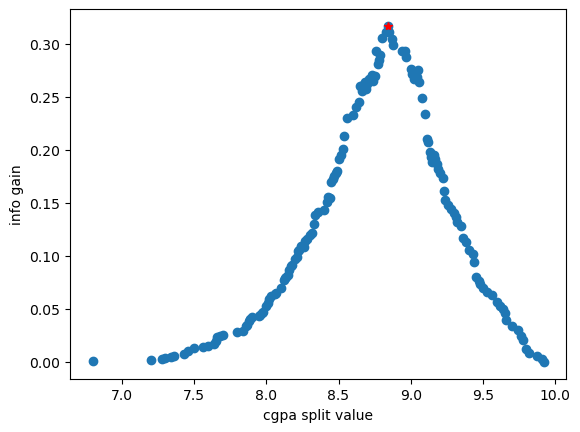

In [13]:
# Visualise information gain
plt.plot(ig_table['split_value'], ig_table['info_gain'],'o')
plt.plot(ig_table['split_value'].iloc[0], ig_table['info_gain'].iloc[0],'r*')
plt.xlabel('cgpa split value')
plt.ylabel('info gain')

# 3. Evaluation

Model Accuarcy

In [14]:
y_pred = dt.predict(x_test)
# print(dt.score(x_test, y_test)) # .score is the same as accuracy_score
print(accuracy_score(y_test, y_pred))

0.8


[[69 12]
 [12 27]]


<AxesSubplot:>

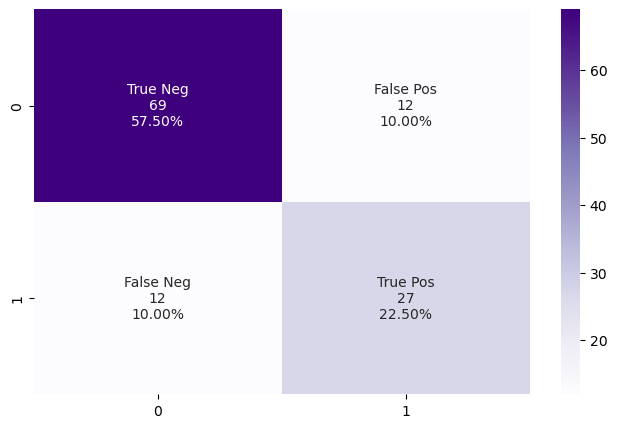

In [15]:
# Confusion Matrix
model_matrix = confusion_matrix(y_test, y_pred)
print(model_matrix)

# Visualize
fig, ax = plt.subplots(figsize=(8,5))

# setting variables
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in model_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in model_matrix.flatten()/np.sum(model_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(model_matrix, annot=labels, fmt='', cmap='Purples')

# code using plot_confusion_matrix
# uncomment to show
# plot_confusion_matrix(dt, x_test, y_test, display_labels =['Unlikely Admit', 'Likely Admit'], cmap='Purples')

# 4. Decision Tree Pruning

### Choosing best CCP_aplha

In [38]:
# pruning
pruning = dt.cost_complexity_pruning_path(x_train, y_train)

# capture the ccp_alphas and impurities values in a variable
ccp_alphas = pruning.ccp_alphas
impurities = pruning.impurities
# check ccp_alphas value
ccp_alphas

array([0.        , 0.00235003, 0.00285714, 0.00345946, 0.00348739,
       0.00489796, 0.00595238, 0.00637755, 0.00665411, 0.00858516,
       0.01190476, 0.01320612, 0.02128558, 0.31661719])

### Create multiple decision tree's with different ccp_alphas value and stored it in a list

In [40]:
dt_list = []
for i in ccp_alphas:
    # random_state = 1 for checking
    dt= DecisionTreeClassifier(random_state=0, ccp_alpha= i)
    dt.fit(x_train, y_train)
    dt_list.append(dt)

# dt_list

### Train and Test accuracy score

In [41]:
# Save the accuracy scores both for the training and testing dataset for each Decision tree's in "dt_list".
train_score = [dt.score(x_train, y_train) for dt in dt_list]
test_score  = [dt.score(x_test, y_test) for dt in dt_list]

# check train vs test scores
pd.DataFrame({"train score":train_score, 'test score':test_score}).head(5)

,train score,test score
0,1.000000,0.800000
1,0.992857,0.808333
2,0.989286,0.800000
3,0.985714,0.808333
4,0.978571,0.816667


### Visualize

(0.0, 0.015)

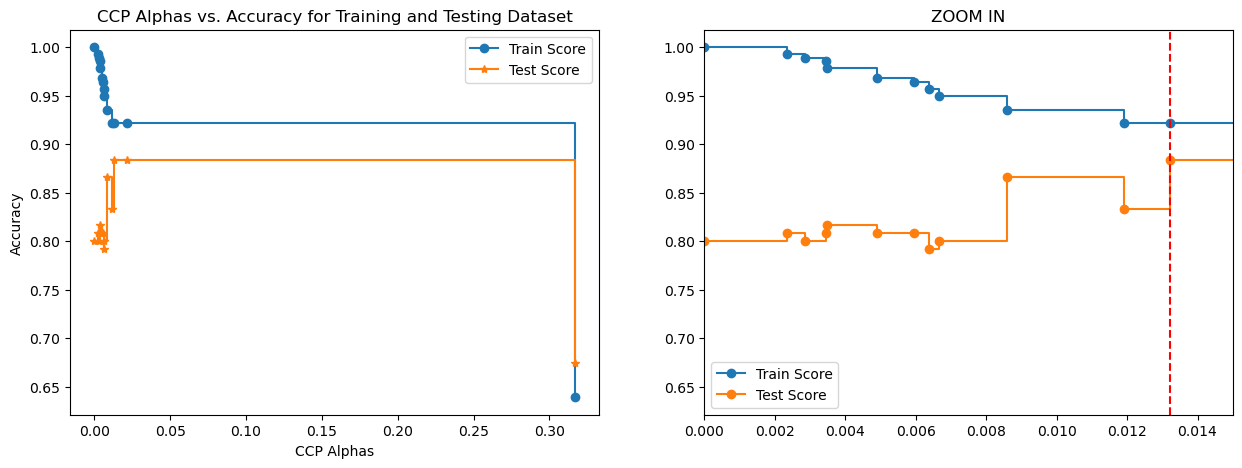

In [42]:
# Plot the accuracy scores vs ccp_alphas both for the training and testing dataset 
plt.figure(figsize=(15, 5)) 

ax1 = plt.subplot(1,2,1)
plt.plot(ccp_alphas, train_score, marker='o', label='Train Score', drawstyle='steps-post')
plt.plot(ccp_alphas, test_score, marker='*', label='Test Score', drawstyle='steps-post')

ax1.set_title('CCP Alphas vs. Accuracy for Training and Testing Dataset')
ax1.set_xlabel('CCP Alphas')
ax1.set_ylabel('Accuracy')
ax1.legend()

#### ZOOM IN 
ax2 = plt.subplot(1,2,2)
plt.plot(ccp_alphas, train_score, marker='o', label='Train Score', drawstyle='steps-post')
plt.plot(ccp_alphas, test_score, marker='o', label='Test Score', drawstyle='steps-post')
plt.axvline(0.013206117854180417, color='r', linestyle='--')
ax2.legend()
ax2.set_title('ZOOM IN')
plt.xlim(.0,.015)

The graph show us that CCP_alpha .013 might be the best one to pick. But how does this alpha perform in different train/test dataset?

### `Cross Validation` using the best CCP Alpha
Testing our new found alpha 0.013206117854180417.

In [43]:
# use random state = 0 , same state as our original tree 
# were just applying our new ccp_alpha here
dt= DecisionTreeClassifier(random_state=0, ccp_alpha= 0.013206117854180417)

In [44]:
# 5 fold cross validation
scores = cross_val_score(dt, x_train, y_train,cv=5)
scores

array([0.91071429, 0.92857143, 0.89285714, 0.91071429, 0.85714286])

In [46]:
df_cv = pd.DataFrame(data={'cross_fold_tree_number': range(5), 'accuracy': scores})
df_cv

,cross_fold_tree_number,accuracy
0,0,0.910714
1,1,0.928571
2,2,0.892857
3,3,0.910714
4,4,0.857143


### Visualize

<AxesSubplot:xlabel='cross_fold_tree_number'>

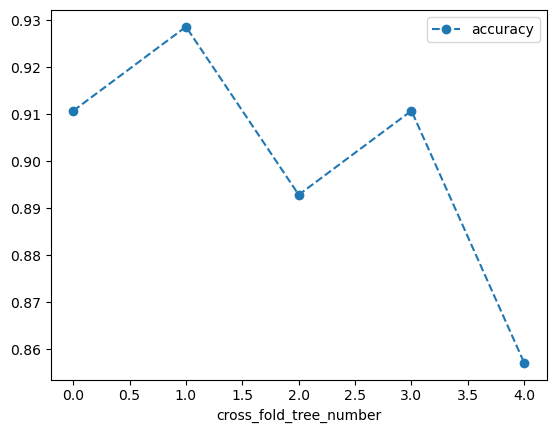

In [49]:
df_cv.plot('cross_fold_tree_number', 'accuracy', linestyle='--', marker='o' )

The graph shows using different training and testing dataset with same alpha(0.013), accuracy scores are fluctuating from 0.86 up to 0.93 acccuracy score.

### Check again the different alphas with cross validation
Using 5 fold validation each in our ccp_alpha list. Get its mean and standard devation.

In [54]:
alpha_cv = []

for i in ccp_alphas:
    # random_state = 0, for checking
    dt= DecisionTreeClassifier(random_state=0, ccp_alpha= i)
    scores = cross_val_score(dt, x_train, y_train,cv=5)
    alpha_cv.append([i, np.mean(scores), np.std(scores)])

alpha_cv

[[0.0, 0.9107142857142858, 0.01956151991089876],
 [0.002350030921459491, 0.925, 0.023690177073967138],
 [0.0028571428571428567, 0.925, 0.023690177073967138],
 [0.003459461375748921, 0.9214285714285715, 0.018210783977117073],
 [0.003487394957983191, 0.9214285714285715, 0.018210783977117073],
 [0.00489795918367347, 0.9214285714285715, 0.02672612419124243],
 [0.005952380952380953, 0.9214285714285714, 0.029014422873699864],
 [0.00637755102040816, 0.9178571428571427, 0.034992710611188284],
 [0.006654109919830003, 0.9178571428571427, 0.034992710611188284],
 [0.008585164835164834, 0.9071428571428571, 0.03642156795423417],
 [0.011904761904761904, 0.9, 0.031134992453861955],
 [0.013206117854180417, 0.9, 0.024222607082590265],
 [0.021285581565418696, 0.9107142857142858, 0.01956151991089876],
 [0.31661718540720335, 0.7964285714285715, 0.12555997022319246]]

accuracy_mean is the mean of 5 fold cross validation using each ccp_alpha.

In [56]:
df_cv2 = pd.DataFrame(alpha_cv, columns=['alpha', 'accuracy_mean', 'std'])
# remove last row (outliers)
df_cv2  = df_cv2[:-1]
df_cv2.head(5)

,alpha,accuracy_mean,std
0,0.000000,0.910714,0.019562
1,0.002350,0.925000,0.023690
2,0.002857,0.925000,0.023690
3,0.003459,0.921429,0.018211
4,0.003487,0.921429,0.018211


### Visualize

<AxesSubplot:xlabel='alpha'>

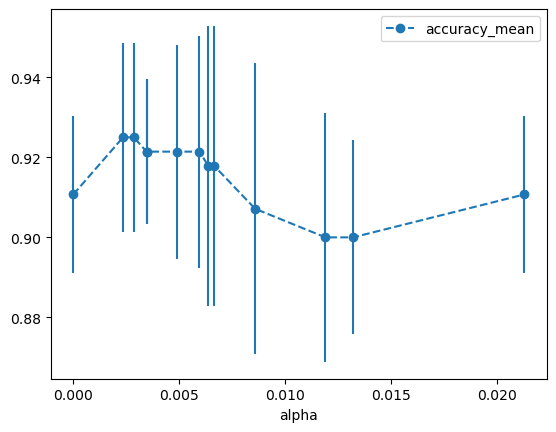

In [57]:
df_cv2.plot(x = 'alpha',
            y = 'accuracy_mean',
            yerr = 'std',
            linestyle = '--',
            marker = 'o' )

### Sort in Descending order

In [58]:
df_cv2.sort_values('accuracy_mean',ascending=False).head(5)

,alpha,accuracy_mean,std
1,0.002350,0.925000,0.023690
2,0.002857,0.925000,0.023690
3,0.003459,0.921429,0.018211
4,0.003487,0.921429,0.018211
5,0.004898,0.921429,0.026726


Using cross validation, instead of using alpha 0.013 we can use the alpha value at 0.002857 which might be better in overall performance.

# 5. Pruned Decision Tree

Decision Tree with the new found best overall alpha 

In [59]:
best_ccp_alpha = 0.002857

In [60]:
# note: I play with different max_depth value here to get the best accuracy score.
# but we can also do a 'for loop' if necessary.
dt = DecisionTreeClassifier(random_state=0,
                            ccp_alpha = best_ccp_alpha,
                            max_depth=3)
# fit the model
dt.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.002857, max_depth=3, random_state=0)

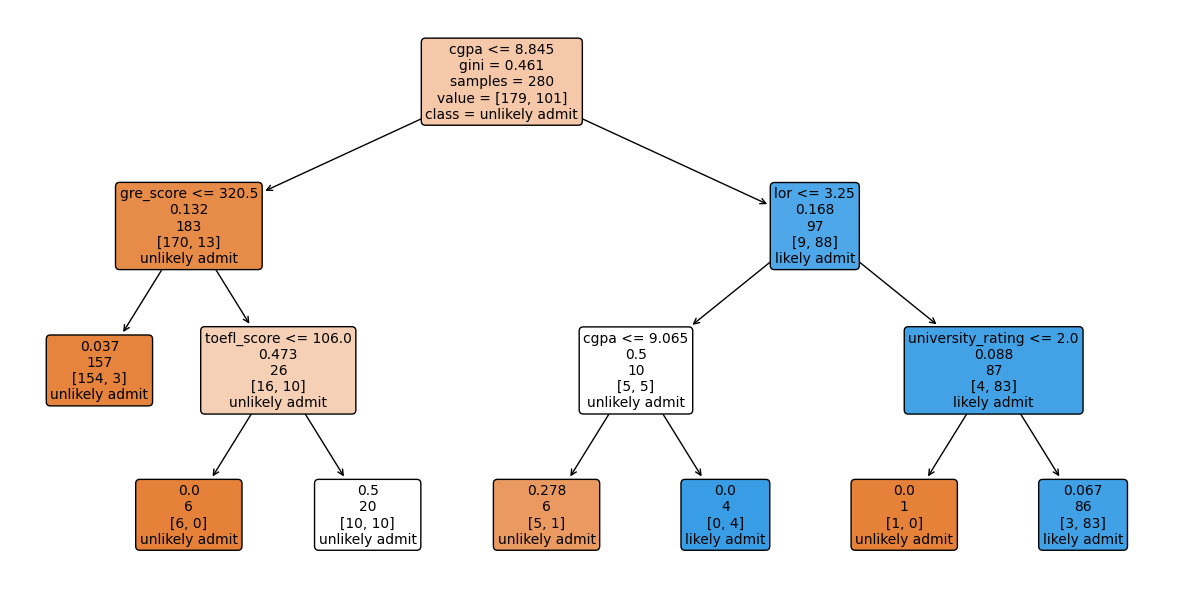

In [61]:
plt.figure(figsize=(15, 7.5))
tree.plot_tree(dt, feature_names = x_train.columns,  
               max_depth=None, class_names = ['unlikely admit', 'likely admit'],
               label='root', filled=True, rounded = True)
plt.show()

`Decission Tree Interpretation`

- Left side = True
- Right side = False

`Unlikely admit`
1. CGPA less than or equal to 8.845 are unlikely to admit.
2. University rating is less than or equal to 2.0


`Likely Admit`
1. CGPA higher than 8.845 need their Letter of Recomendation(LOR) score to be higher than 3.25 given that LOR is from a high rating university(univerty rating must be greater than 2.0).
2. GCPA with score above 9.065 is excepted from low LOR score.
3. For CGPA score between 8.846 and 9.065 need high LOR score (higher than 3.25).

### Model Evaluation

In [62]:
y_pred = dt.predict(x_test)
# print(dt.score(x_test, y_test)) # .score is the same as accuracy_score
print(accuracy_score(y_test, y_pred))

0.85


[[74  7]
 [11 28]]


<AxesSubplot:>

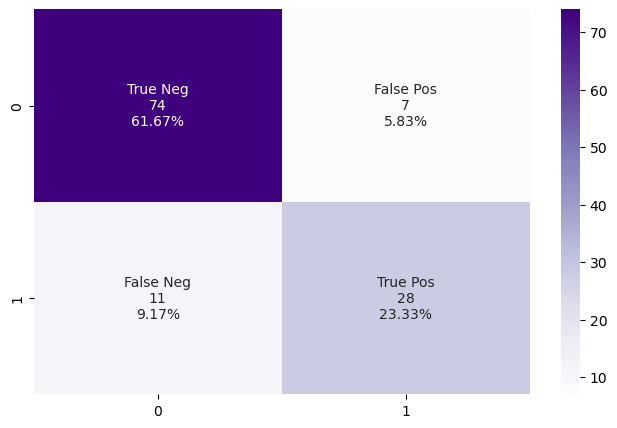

In [63]:
# Confusion Matrix
model_matrix = confusion_matrix(y_test, y_pred)
print(model_matrix)

# Visualize
fig, ax = plt.subplots(figsize=(8,5))

# setting variables
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in model_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in model_matrix.flatten()/np.sum(model_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(model_matrix, annot=labels, fmt='', cmap='Purples')

### Conclusion
Before we had 80% accuracy, after prunning the Tree we have now a significantly 85% model accuracy.

# 6.Random Forest Implementation
Intead of using 1 tree, we can use 10 or 100 more trees. Each tree will have a vote on weather each point are true or false then the majority of votes will be our final output.

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
rf = RandomForestClassifier(n_estimators=10, max_depth=3) 

In [66]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(X,y, random_state=0, test_size=0.3)
rf.fit(x_train2, y_train2)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [67]:
y_pred2 = rf.predict(x_test2)
model_matrix2 = confusion_matrix(y_test2, y_pred2)
print(model_matrix2)

[[76  5]
 [ 9 30]]


In [68]:
rf.score(x_test2, y_test2)

0.8833333333333333

Visualize random forest (all trees)

In [37]:
# for i in range(len(rf.estimators_)):
#         plt.figure(figsize = (15,15))
#         tree.plot_tree(rf.estimators_[i] , filled =True)
#         plt.show()

***

- fin